In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask

In [2]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38993 instead
  warnings.warn(


In [3]:
VC = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/VAR_PACE_sst.nc", chunks = {"time":12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [4]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/ctrl_sst.nc", chunks = {"time":12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [5]:
po_pace_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/sst.nc", chunks = {"time":12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [6]:
oc_pace_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/obs_c_sst.nc", chunks = {"time":12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [7]:
OBS = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/hadisst_clim_1x1.nc")

In [8]:
OBS = OBS.__xarray_dataarray_variable__

In [9]:
HAD_ANOM = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/HAD_anoms_full.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [10]:
HA = HAD_ANOM.rename({"GRID_X_T": "longitude", "GRID_Y_T": "latitude"})
#create the output grid
ds_out = xe.util.grid_global(1, 1)
ds_out = ds_out.drop({'lon_b', 'lat_b'})
#rename grid coords
ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
#drop the coords on input ds
#ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
#create regridder
regridder_1deg = xe.Regridder(HA, ds_out, 'bilinear', periodic=True)

In [11]:
HA_r = regridder_1deg(HA)
HA_r= HA_r.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
HA_r= HA_r.drop({"latitude", "longitude"}).rename({'x': 'longitude', 'y': 'latitude'})

In [12]:
HA_r = HA_r.temp

In [13]:
def regrid_ACCESS(ds):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds['sst'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [14]:
ctrl = regrid_ACCESS(ctrl_sst)
ctrl = ctrl.compute()

In [15]:
VC = regrid_ACCESS(VC)
VC = VC.compute()

In [16]:
MC = regrid_ACCESS(po_pace_sst)
MC = MC.compute()

In [17]:
OC = regrid_ACCESS(oc_pace_sst)
OC = OC.compute()

In [18]:
#read and load in pascals runs

In [19]:
s_ctrl = xr.open_dataset("/g/data/e14/sm2435/Pascal_runs/Pacemakers/REFADA_1m_000101_021012_tsurf.nc").tsurf.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
s_oc = xr.open_dataset("/g/data/e14/sm2435/Pascal_runs/Pacemakers/FTP_1m_000101_005012_tsurf.nc").tsurf.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
s_mc = xr.open_dataset("/g/data/e14/sm2435/Pascal_runs/Pacemakers/FTPC_1m_000101_011012_tsurf.nc").tsurf.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:153: SerializationWarning: Ambiguous reference date string: 1-01-31 23:54:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-31 23:54:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axi

In [20]:
#load in LSM
LSM = xr.open_dataset("/g/data/e14/sm2435/Pascal_runs/Pacemakers/echam_mesh_mask_oce.nc").nmask.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')[::-1]


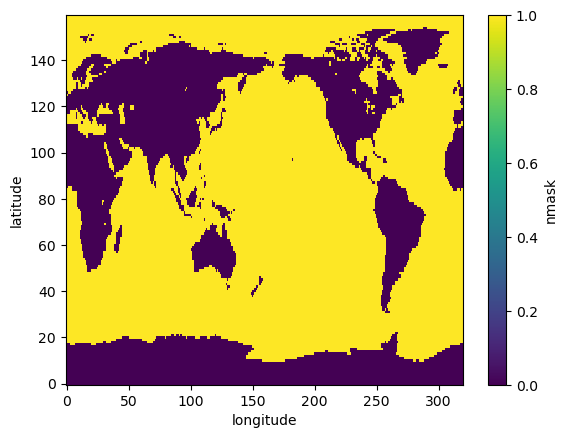

In [21]:
LSM.plot()

In [22]:
s_oc = s_oc.where(LSM==1)
s_ctrl = s_ctrl.where(LSM==1)
s_mc = s_mc.where(LSM==1)


In [23]:
#move the longitudes from 0-360 to -180-180
def roll_lon(df):
    df.coords['longitude'] = (df.coords['longitude'] + 180) % 360 - 180
    df = df.sortby(df.longitude)
    return df

In [24]:
s_oc = roll_lon(s_oc)
s_ctrl = roll_lon(s_ctrl)
s_mc = roll_lon(s_mc)

In [25]:
s_ctrl = s_ctrl.load()
s_oc = s_oc.load()
s_mc = s_mc.load()

In [26]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta
def NINO34_sst(DS):
     return (DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
def NINO34(DS):
     return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
def dmi(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return  WTIO-SETIO
def siod(DS):
    west = ssta(DS).sel(latitude=slice(-37, -27),longitude=slice(55, 65)).mean(['latitude', 'longitude'])
    east = ssta(DS).sel(latitude=slice(-28, -18),longitude=slice(90, 100)).mean(['latitude', 'longitude'])
    return  west-east
def Ningaloo2(DS):
    return ssta(DS).sel(latitude=slice(-28, -22),longitude=slice(112, 114)).mean(['latitude', 'longitude'])

In [27]:
#now write a fucntion to output bias and to optioanlly plot
def sst_bias(model, obs, freq=None, plot=None, temp_scale = 2):
    """
    Lorem ipsum dolor sit amet, consetetur sadipscing elitr,
    sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam
    
    Parameters
    ----------
    model : argument of type int
        DataArray of model run 
    obs : argument of type int
        Lorem ipsum dolor sit amet
    freq : {‘monthly’, ‘annual’}, optional
        if None default to 'monthly'
    plot : True or False
        if true, plot is made, if false then no
    temp_scale : 2 (optional)
        set to 2 automatically, sets vmin vmax

    """
    #check frequency of sampling, defaukt to monthly if not specified
    if freq == None:
        freq = 'monthly'
    if plot == None:
        plot = False
    #check what the obs file is time or month already
    if obs.dims[0] == "time":
        obs_mon = obs.groupby('time.month').mean('time')
        obs_mn = obs.mean('time')
    else:
        obs_mon = obs 
        obs_mn = obs.mean('month')
    
    
    #calculate the bias
    if freq == "monthly":
        bias = (model.groupby('time.month').mean('time') - obs_mon)
        if plot == True:
            fg = bias.plot.contourf(col='month', col_wrap = 4,  transform=ccrs.PlateCarree(),
                                 subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)}, 
                                  figsize=(20,8), facecolor = 'white', vmin = -1*temp_scale, vmax = temp_scale, levels =10, extend = 'both',  cmap = 'RdBu_r',
                                    cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
            for i, ax in enumerate(fg.axes.flat):
                ax.coastlines()
                #ax.set_facecolor('grey')
                gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
                if i in [0,1,2,3,4,5,6,7]:
                    gl.bottom_labels = False
                if i in [1,2,3,5,6,7,9,10,11]:
                    gl.left_labels = False
                gl.top_labels = False
                gl.right_labels = False               
            #now add the month labels\n",
            titles =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul',
                     'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            for ax,title in zip(fg.axes.flatten(),titles):
                ax.set_title(title )
            return
        elif plot == False:
            return bias
    elif freq == "annual":
        bias = (model.mean('time') - obs_mn)
        if plot == True:
            plt.figure(figsize = (12,8))
            ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
            bias.plot.contourf(ax=ax, vmin = -1*temp_scale, vmax = temp_scale, cmap = "RdBu_r", levels = 10, extend = 'both',
                   transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
            ax.set_title('Annual mean SST bias')
            ax.coastlines(color = 'k')
            ax.gridlines()
            #ax.set_facecolor('grey')
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            return 
        elif plot == False:
            return bias

Text(0.5, 1.0, 'Control - OBS')

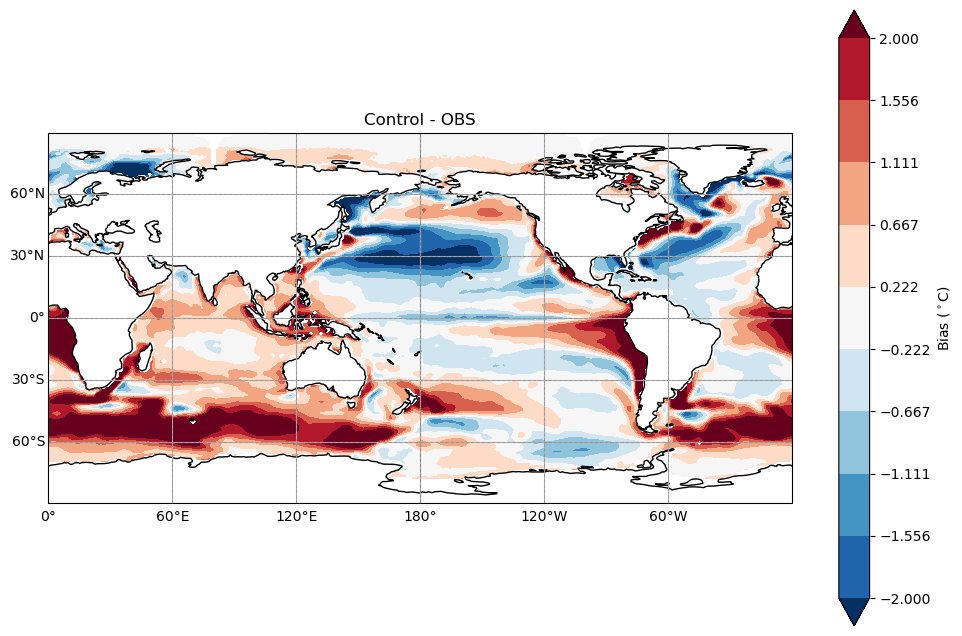

In [28]:
sst_bias(ctrl, OBS,  "annual", plot=True, temp_scale=2)
plt.title("Control - OBS")

Text(0.5, 1.0, 'No bias - OBS')

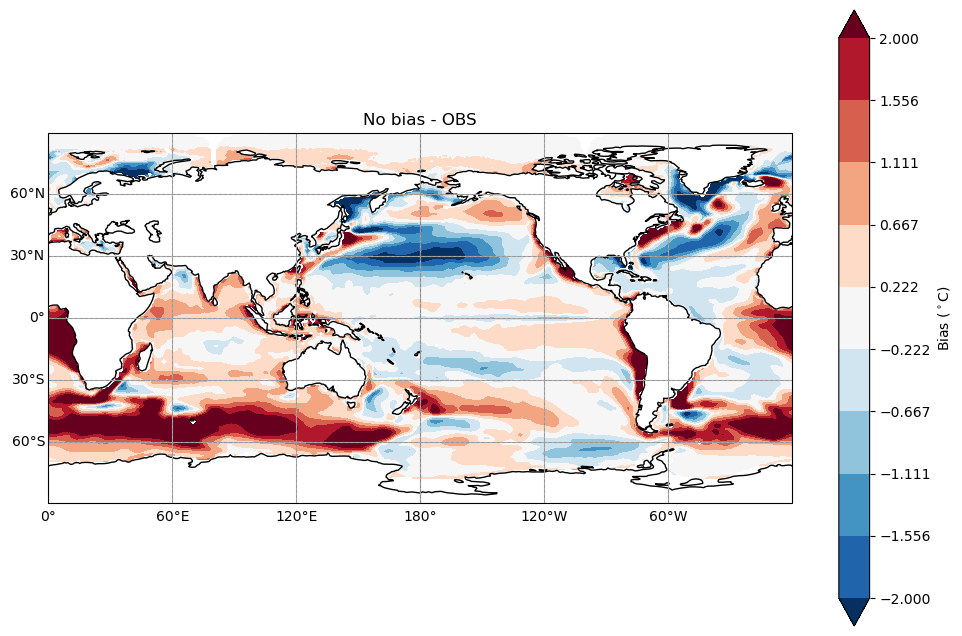

In [29]:
sst_bias(VC, OBS,  "annual", plot=True, temp_scale=2)
plt.title("No bias - OBS")

Text(0.5, 1.0, 'No bias with var - no var')

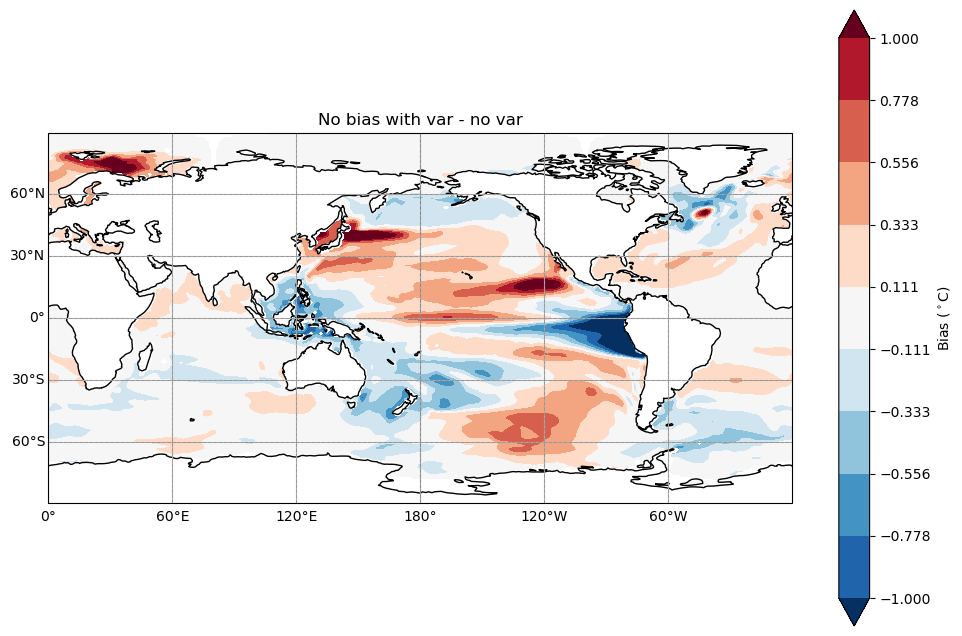

In [30]:
sst_bias(VC, MC,  "annual", plot=True, temp_scale=1)
plt.title("No bias with var - no var")

Text(0.5, 1.0, 'No bias with var - no bias no var')

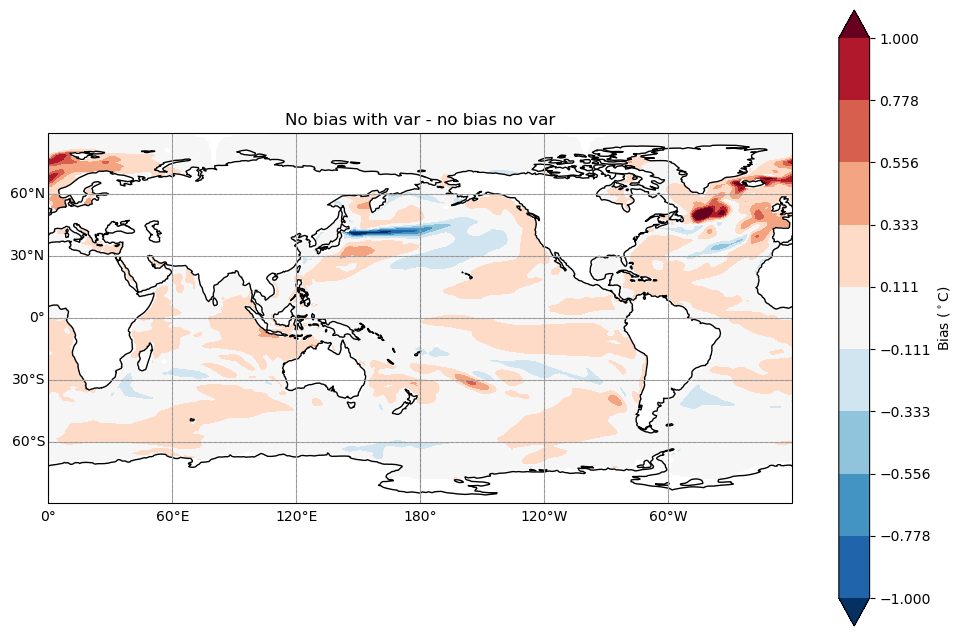

In [31]:
sst_bias(VC, OC,  "annual", plot=True, temp_scale=1)
plt.title("No bias with var - no bias no var")

Text(0.5, 1.0, 'No bias - ctrl')

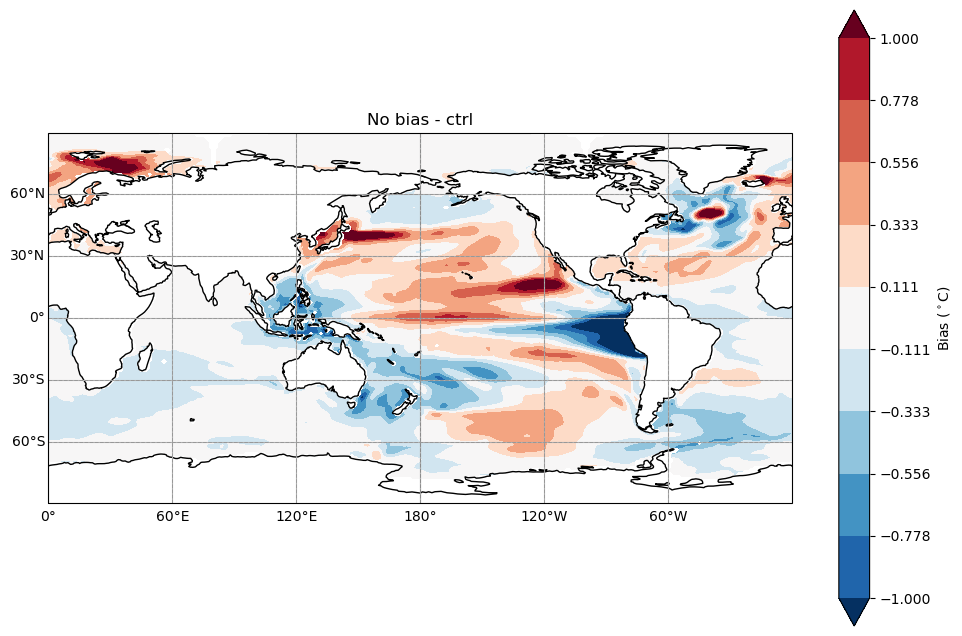

In [32]:
sst_bias(VC, ctrl,  "annual", plot=True, temp_scale=1)
plt.title("No bias - ctrl")

Text(0.5, 1.0, 'no bias - restore SST')

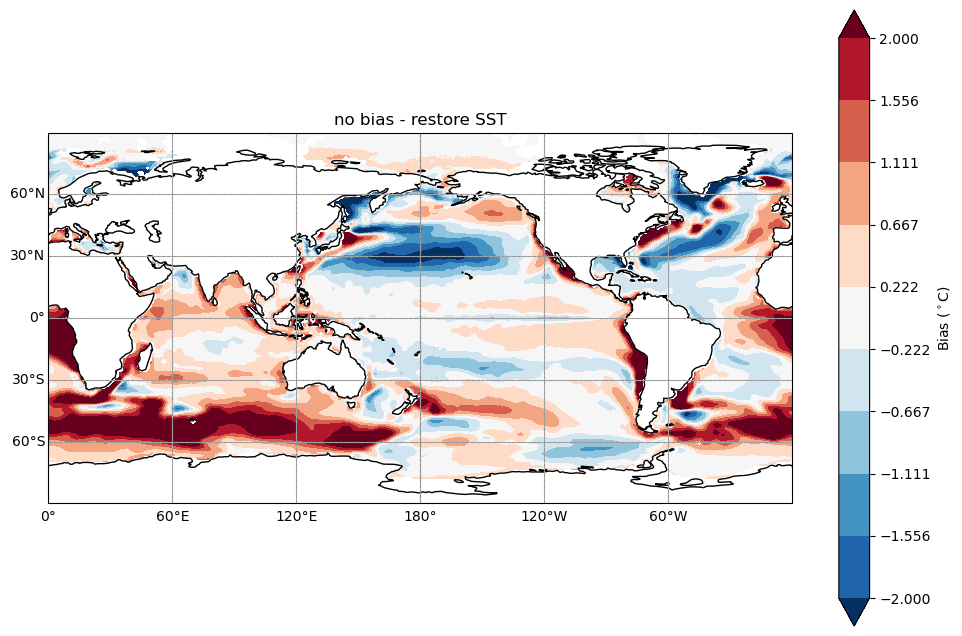

In [33]:
sst_bias(VC, HA_r,  "annual", plot=True, temp_scale=2)
plt.title("no bias - restore SST")

Text(0.5, 1.0, 'ctrl - restore SST')

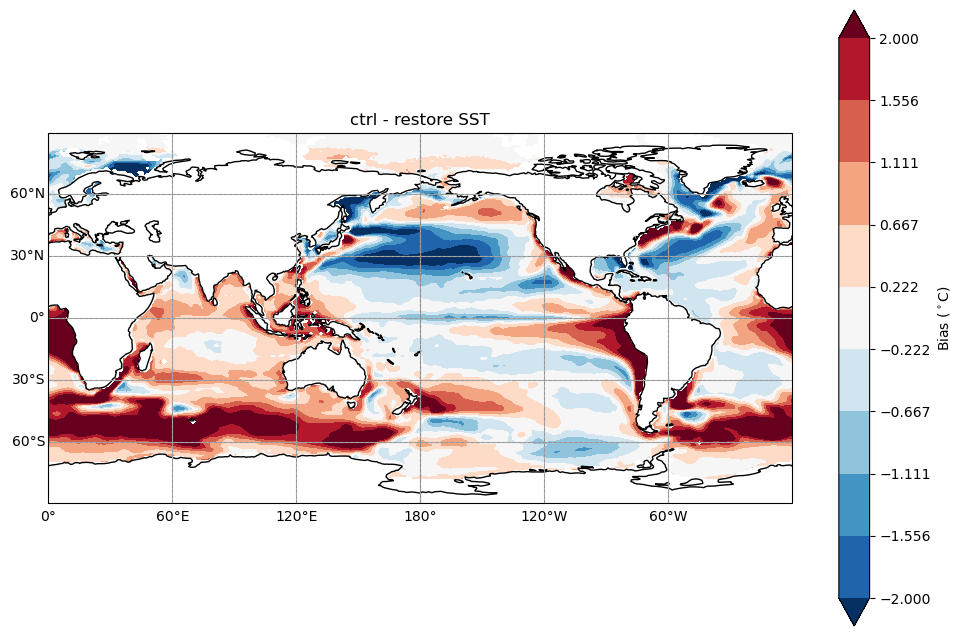

In [34]:
sst_bias(ctrl, HA_r,  "annual", plot=True, temp_scale=2)
plt.title("ctrl - restore SST")

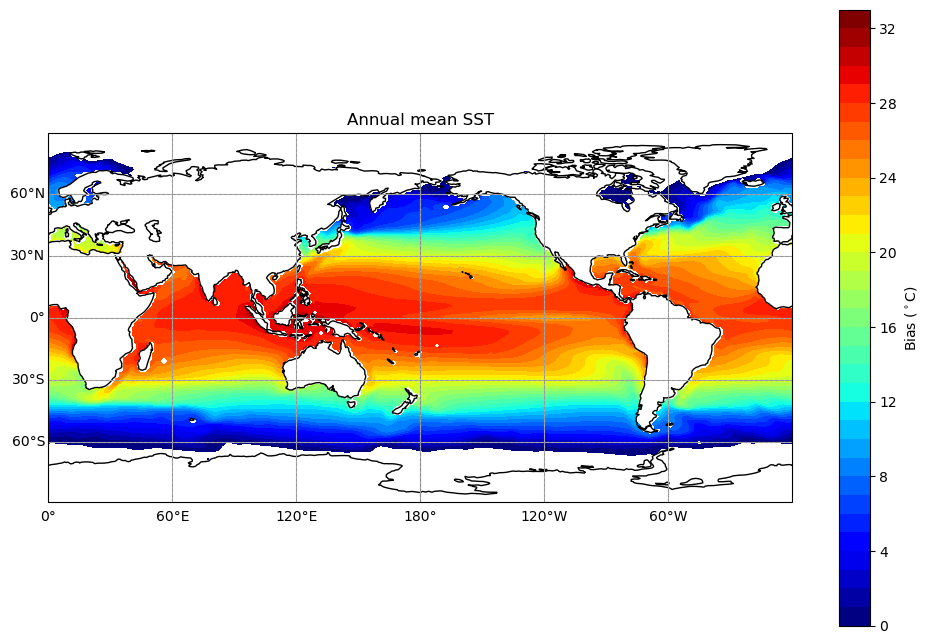

In [35]:
#plot mean state of SST
plt.figure(figsize = (12,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ctrl.mean('time').plot.contourf(ax=ax, vmin = 0, vmax = 33, cmap = "jet", levels = 34, extend = 'neither',
       transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
ax.set_title('Annual mean SST')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

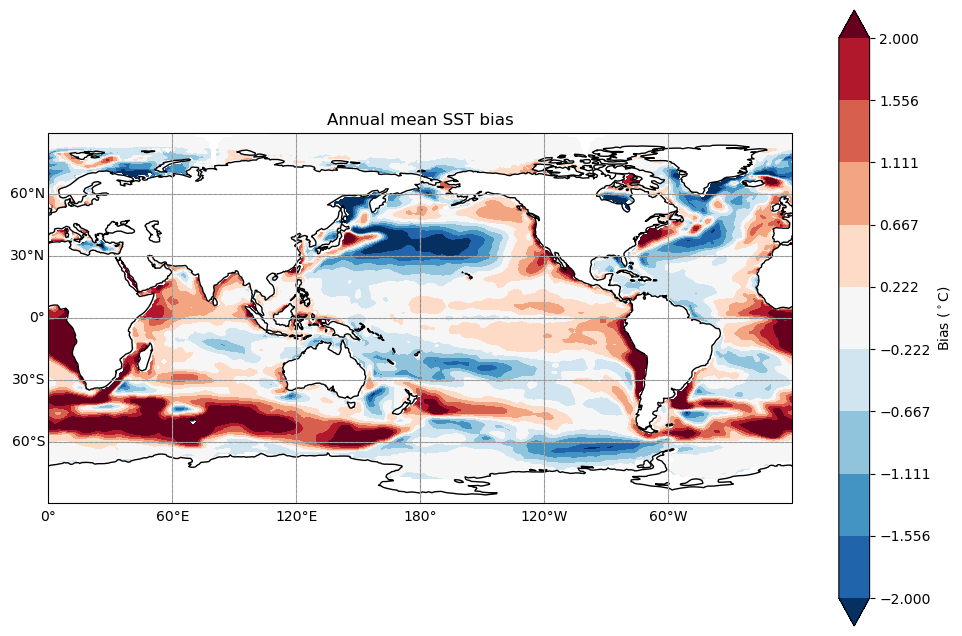

In [36]:
#plot mean state of SST
plt.figure(figsize = (12,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
(VC.groupby('time.month').mean('time').sel(month = [9,10,11]).mean('month') - 
OBS.sel(month = [9,10,11]).mean('month')).plot.contourf(ax=ax, vmin = -2, vmax = 2, cmap = "RdBu_r", levels = 10, extend = 'both',
       transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
ax.set_title('Annual mean SST bias')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

Text(0.5, 1.0, 'model clims - ctrl sintex')

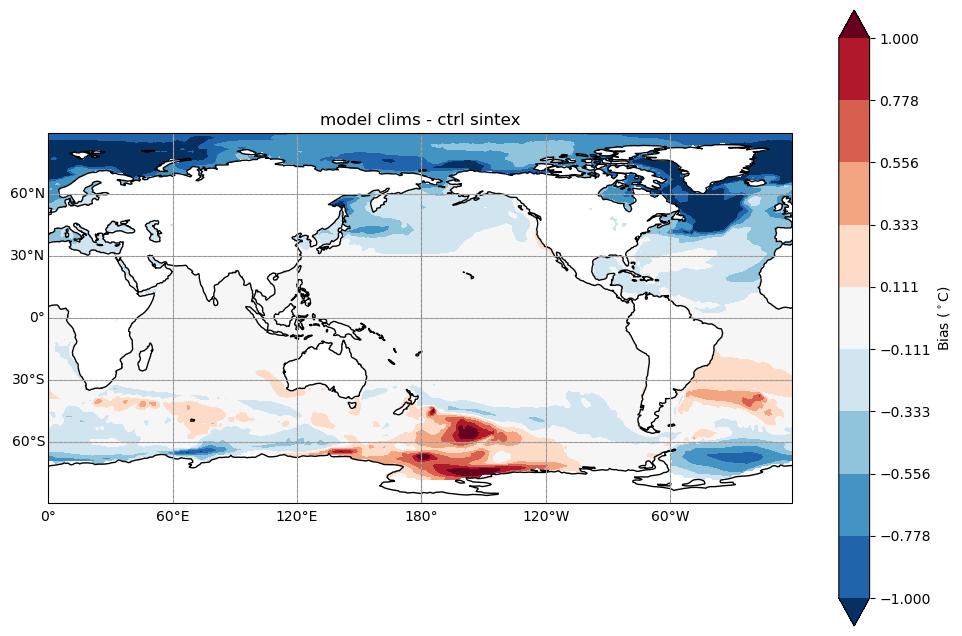

In [36]:
sst_bias(s_mc, s_ctrl,  "annual", plot=True, temp_scale=1)
plt.title("model clims - ctrl sintex")

Text(0.5, 1.0, 'obs clims - ctrl sintex')

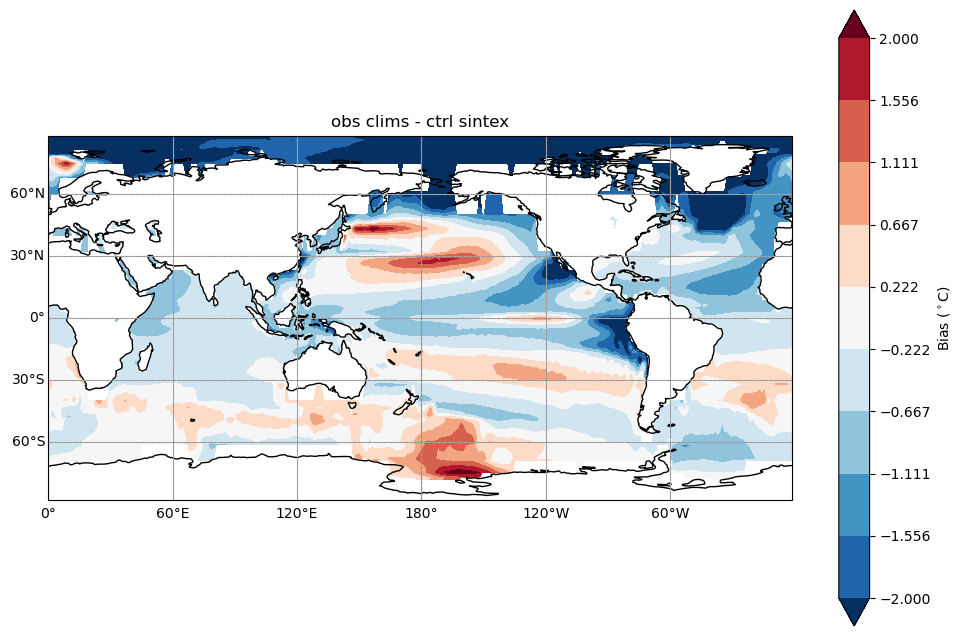

In [37]:
sst_bias(s_oc, s_ctrl,  "annual", plot=True, temp_scale=2)
plt.title("obs clims - ctrl sintex")

Text(0.5, 1.0, 'NINO34 monthly standard deviation')

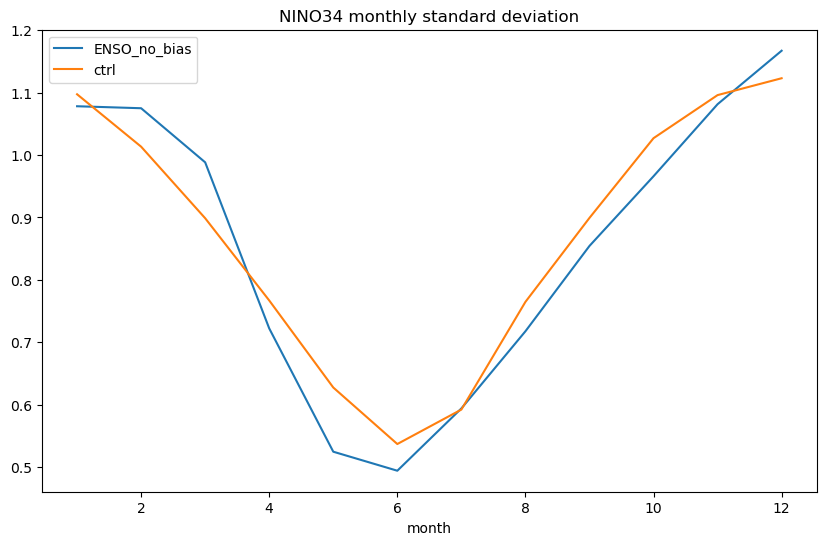

In [44]:
plt.figure(figsize = (10,6))
NINO34(VC).groupby('time.month').std('time').plot(label = "ENSO_no_bias")
NINO34(ctrl).groupby('time.month').std('time').plot(label = "ctrl")
#NINO34(MC).groupby('time.month').std('time').plot(label = "no_ENSO")
#NINO34(OC).groupby('time.month').std('time').plot(label = "no_ENSO_no_bias")

#NINO34(s_ctrl).groupby('time.month').std('time').plot(c = "tab:orange", ls = '--', label = "sintex_ctrl")
#NINO34(s_mc).groupby('time.month').std('time').plot(c = "tab:green", ls = '--', label = "sintex_no_ENSO")
#NINO34(s_oc).groupby('time.month').std('time').plot(c = "tab:red", ls = '--', label = "sintex_no_ENSO_no_bias")

#dmi(HA_r).sel(time = slice('0951-01-01','0960-12-31' )).plot(label = "restor_vals")
plt.legend()
plt.title("NINO34 monthly standard deviation")

Text(0.5, 1.0, 'DMI monthly standard deviation \n ACCESS-CM2')

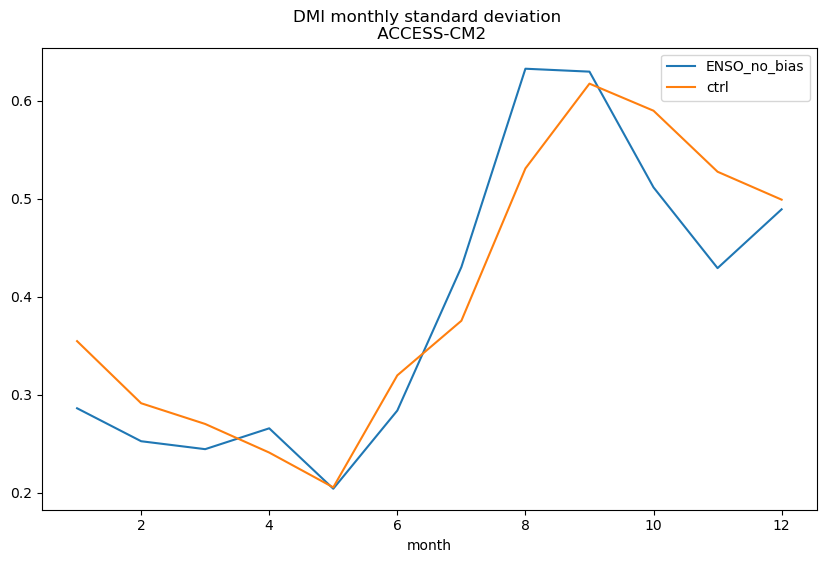

In [45]:
plt.figure(figsize = (10,6))
dmi(VC).groupby('time.month').std('time').plot(label = "ENSO_no_bias")
dmi(ctrl).groupby('time.month').std('time').plot(label = "ctrl")
#dmi(MC).groupby('time.month').std('time').plot(label = "no_ENSO")
#dmi(OC).groupby('time.month').std('time').plot(label = "no_ENSO_no_bias")

#dmi(s_ctrl).groupby('time.month').std('time').plot(c = "tab:orange", ls = '--', label = "sintex_ctrl")
#dmi(s_mc).groupby('time.month').std('time').plot(c = "tab:green", ls = '--', label = "sintex_no_ENSO")
#dmi(s_oc).groupby('time.month').std('time').plot(c = "tab:red", ls = '--', label = "sintex_no_ENSO_no_bias")

#dmi(OBS).plot(label = "HADISST")
plt.legend()
plt.title("DMI monthly standard deviation \n ACCESS-CM2")

Text(0.5, 1.0, 'DMI monthly standard deviation \n SINTEX')

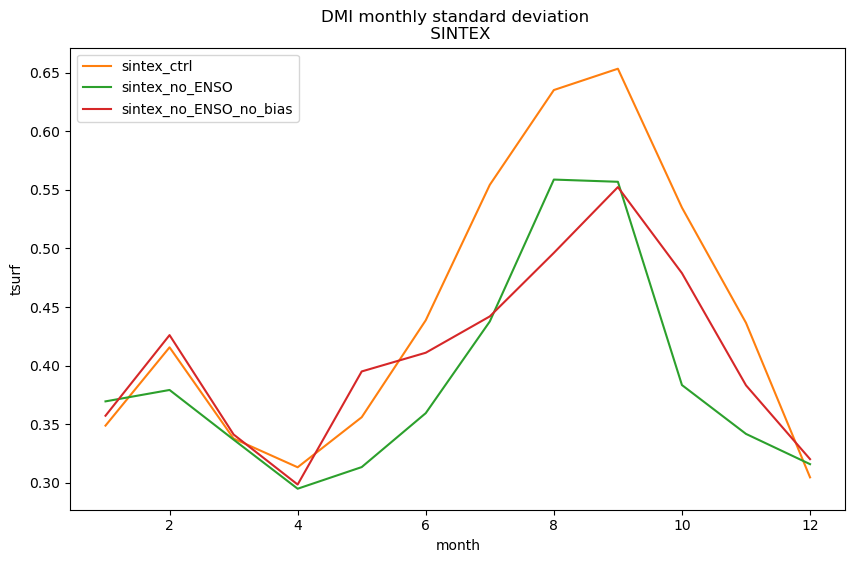

In [86]:
plt.figure(figsize = (10,6))
#dmi(VC).groupby('time.month').std('time').plot(label = "ENSO_no_bias")
#dmi(ctrl).groupby('time.month').std('time').plot(label = "ctrl")
#dmi(MC).groupby('time.month').std('time').plot(label = "no_ENSO")
#dmi(OC).groupby('time.month').std('time').plot(label = "no_ENSO_no_bias")

dmi(s_ctrl).groupby('time.month').std('time').plot(c = "tab:orange", label = "sintex_ctrl")
dmi(s_mc).groupby('time.month').std('time').plot(c = "tab:green", label = "sintex_no_ENSO")
dmi(s_oc).groupby('time.month').std('time').plot(c = "tab:red", label = "sintex_no_ENSO_no_bias")

#dmi(OBS).plot(label = "HADISST")
plt.legend()
plt.title("DMI monthly standard deviation \n SINTEX")

Text(0.5, 1.0, 'NNI monthly standard deviation')

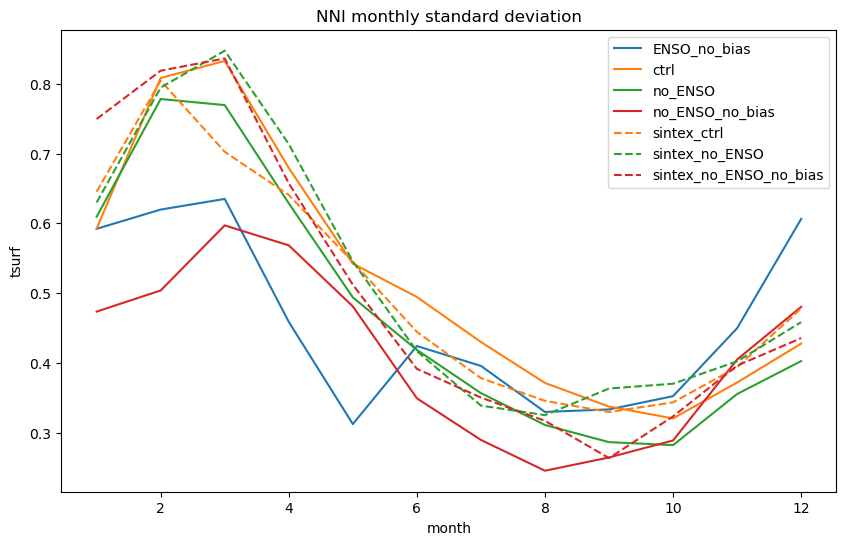

In [89]:
plt.figure(figsize = (10,6))
Ningaloo2(VC).groupby('time.month').std('time').plot(label = "ENSO_no_bias")
Ningaloo2(ctrl).groupby('time.month').std('time').plot(label = "ctrl")
Ningaloo2(MC).groupby('time.month').std('time').plot(label = "no_ENSO")
Ningaloo2(OC).groupby('time.month').std('time').plot(label = "no_ENSO_no_bias")

Ningaloo2(s_ctrl).groupby('time.month').std('time').plot(c = "tab:orange", ls = '--', label = "sintex_ctrl")
Ningaloo2(s_mc).groupby('time.month').std('time').plot(c = "tab:green", ls = '--', label = "sintex_no_ENSO")
Ningaloo2(s_oc).groupby('time.month').std('time').plot(c = "tab:red", ls = '--', label = "sintex_no_ENSO_no_bias")

#dmi(OBS).plot(label = "HADISST")
plt.legend()
plt.title("NNI monthly standard deviation")

In [42]:
#lets plot IOD regressions here

In [37]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [38]:
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['time'], ['time']],# reduce along 'model'
                        )
    return slope

In [39]:
def plot_regression(FN, DS):
    slope = regress(FN(DS), ssta(DS))
    plt.figure(figsize = (10,6))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                            vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
    ax.coastlines(color = 'k')
    ax.gridlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    #ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())
    return

Text(0.5, 1.0, 'ACCESS-CM2 CTRL \nNINO34 SSTA regression')

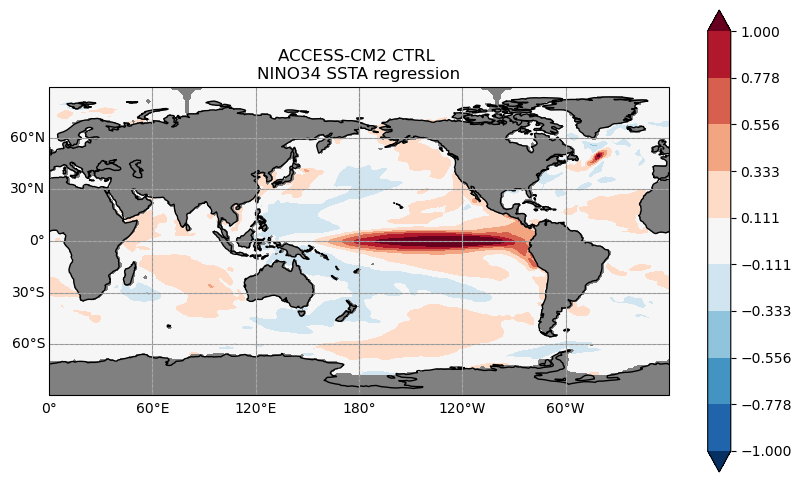

In [48]:
plot_regression(NINO34, VC)
plt.title('ACCESS-CM2 CTRL \nNINO34 SSTA regression')


Text(0.5, 1.0, 'ACCESS-CM2 CTRL \nNINO34 SSTA regression')

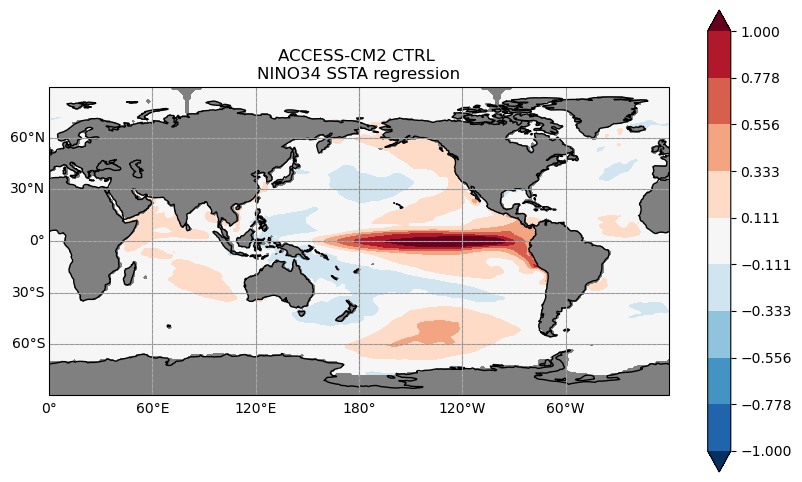

In [64]:
plot_regression(NINO34, ctrl)
plt.title('ACCESS-CM2 CTRL \nNINO34 SSTA regression')


Text(0.5, 1.0, 'SINTEX CTRL \nNINO34 SSTA regression')

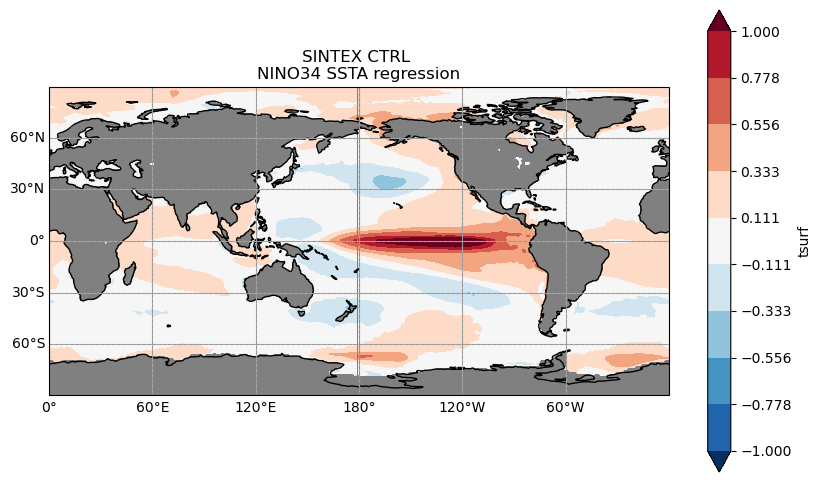

In [65]:
plot_regression(NINO34, s_ctrl)
plt.title('SINTEX CTRL \nNINO34 SSTA regression')


Text(0.5, 1.0, 'ACCESS-CM2 CTRL \nDMI SSTA regression')

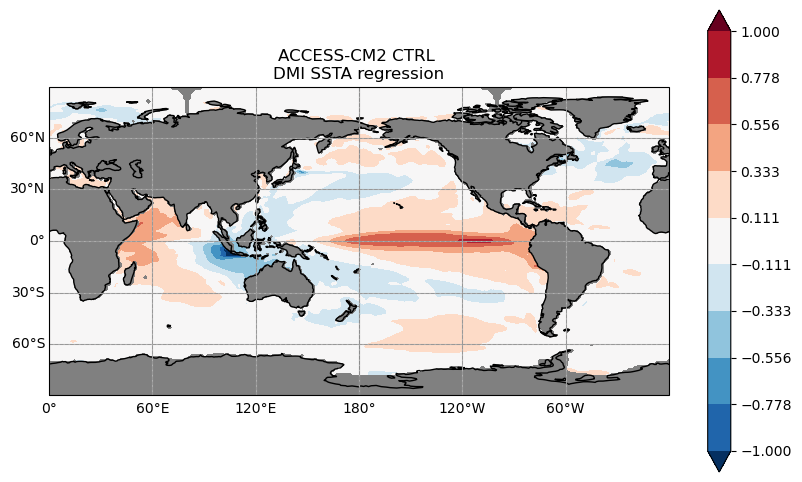

In [66]:
plot_regression(dmi, ctrl)
plt.title('ACCESS-CM2 CTRL \nDMI SSTA regression')


Text(0.5, 1.0, 'SINTEX CTRL \n DMI SSTA regression')

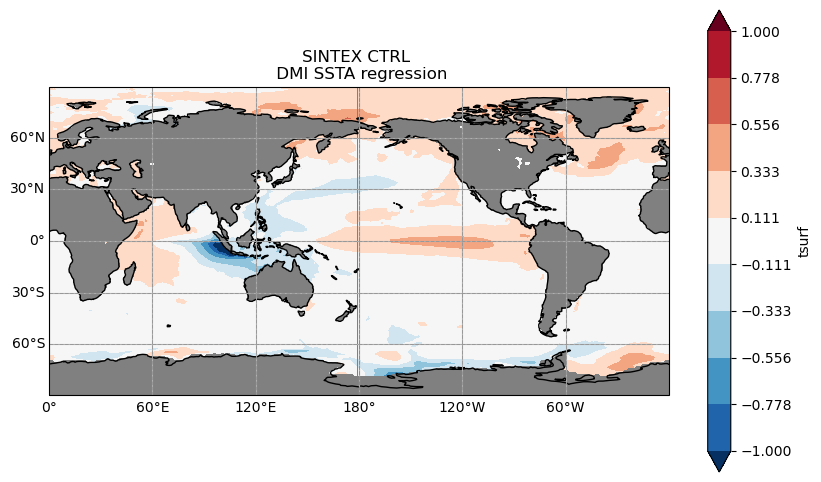

In [70]:
plot_regression(dmi, s_ctrl)
plt.title('SINTEX CTRL \n DMI SSTA regression')


Text(0.5, 1.0, 'ACCESS-CM2 CTRL \n Ningaloo Nino SSTA regression')

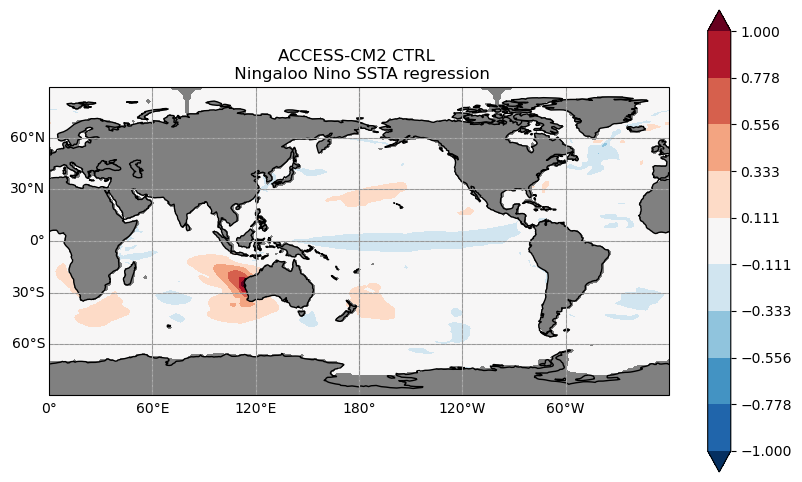

In [71]:
plot_regression(Ningaloo2, ctrl)
plt.title('ACCESS-CM2 CTRL \n Ningaloo Nino SSTA regression')


Text(0.5, 1.0, 'SINTEX CTRL \n Ningaloo Nino SSTA regression')

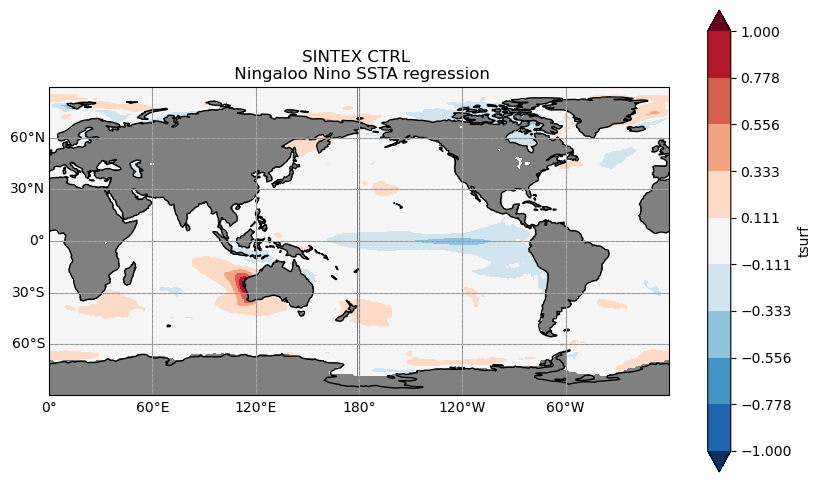

In [72]:
plot_regression(Ningaloo2, s_ctrl)
plt.title('SINTEX CTRL \n Ningaloo Nino SSTA regression')


Text(0.5, 1.0, 'ACCESS-CM2 CTRL \nSubtropical dipole Nino SSTA regression')

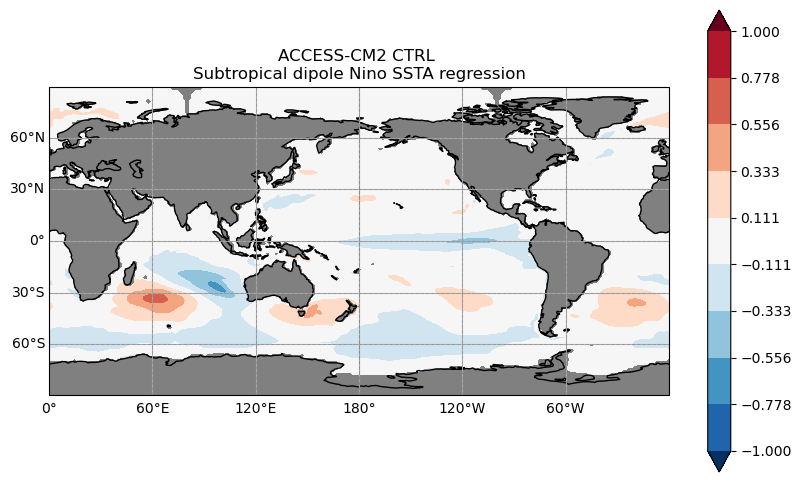

In [73]:
plot_regression(siod, ctrl)
plt.title('ACCESS-CM2 CTRL \nSubtropical dipole Nino SSTA regression')


Text(0.5, 1.0, 'SINTEX CTRL \nSubtropical dipole Nino SSTA regression')

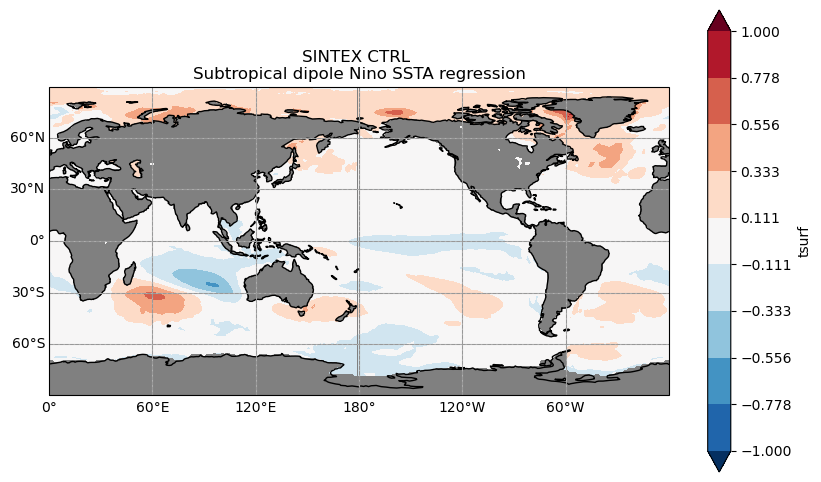

In [74]:
plot_regression(siod, s_ctrl)
plt.title('SINTEX CTRL \nSubtropical dipole Nino SSTA regression')


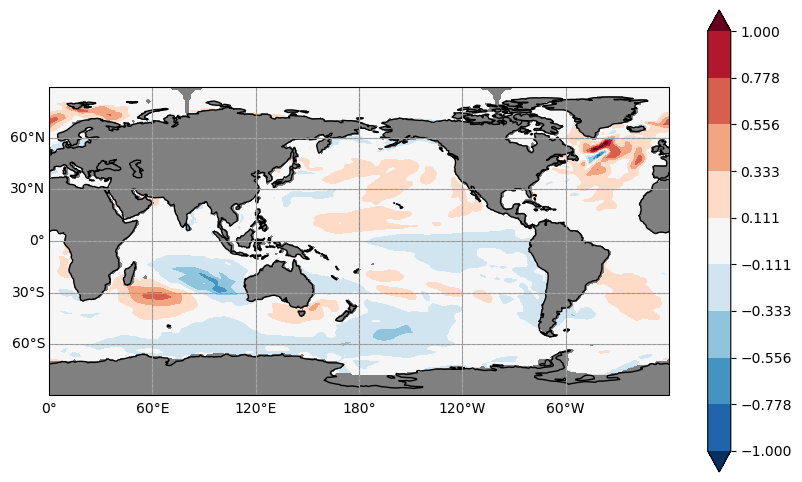

In [56]:
plot_regression(siod, VC)

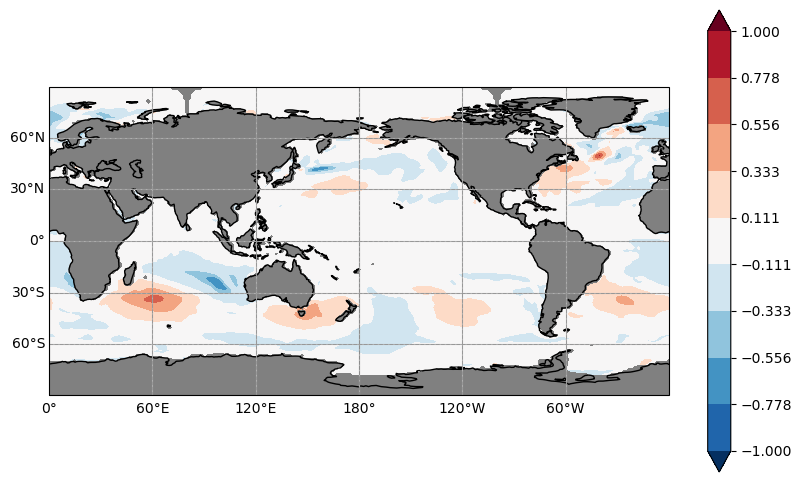

In [59]:
plot_regression(siod, OC)

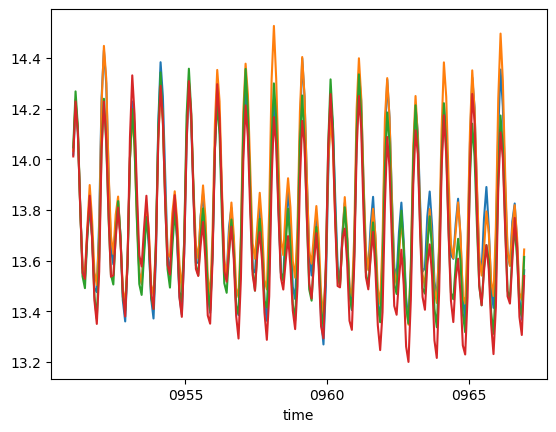

In [57]:
plt.figure(figsize(10,6))
VC.mean(['latitude','longitude']).plot(label = "no bias")
ctrl.mean(['latitude','longitude']).sel(time = slice('0951-01-01','0966-12-31' )).plot(label = "ctrl")
MC.mean(['latitude','longitude']).sel(time = slice('0951-01-01','0966-12-31' )).plot(label = "MC")
OC.mean(['latitude','longitude']).sel(time = slice('0951-01-01','0966-12-31' )).plot(label = "OC")

In [55]:
print(VC.mean(),
ctrl.mean(),
MC.mean(),
OC.mean())

<xarray.DataArray ()>
array(13.769574, dtype=float32) <xarray.DataArray ()>
array(13.770311, dtype=float32) <xarray.DataArray ()>
array(13.728804, dtype=float32) <xarray.DataArray ()>
array(13.68784, dtype=float32)


Text(0.5, 1.0, 'DMI')

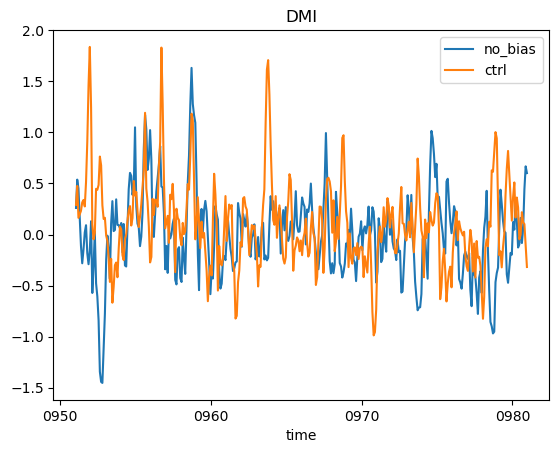

In [42]:
dmi(VC).plot(label = "no_bias")
dmi(ctrl).sel(time = slice('0951-01-01','0980-12-31' )).plot(label = "ctrl")
#dmi(MC).sel(time = slice('0951-01-01','0980-12-31' )).plot(label = "MO")
#dmi(OC).sel(time = slice('0951-01-01','0980-12-31' )).plot(label = "OC")

#dmi(HA_r).sel(time = slice('0951-01-01','0960-12-31' )).plot(label = "restor_vals")
plt.legend()
plt.title("DMI")

Text(0.5, 1.0, 'Nino34 index')

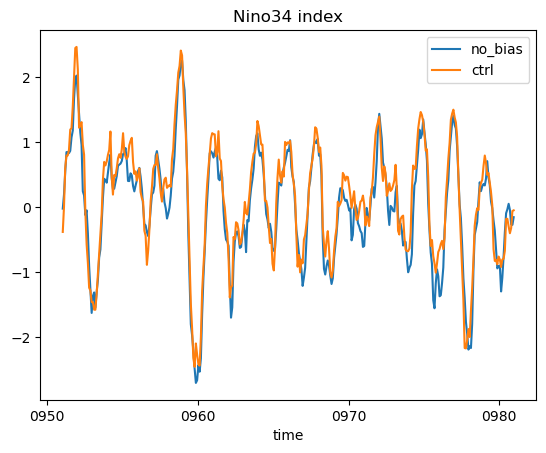

In [47]:
NINO34(VC).plot(label = "no_bias")
NINO34(ctrl).sel(time = slice('0951-01-01','0980-12-31' )).plot(label = "ctrl")
#NINO34(HA_r).sel(time = slice('0951-01-01','0966-12-31' )).plot(label = "restor_vals")
plt.legend()
plt.title("Nino34 index")

Text(0.5, 1.0, 'Nino34 SST')

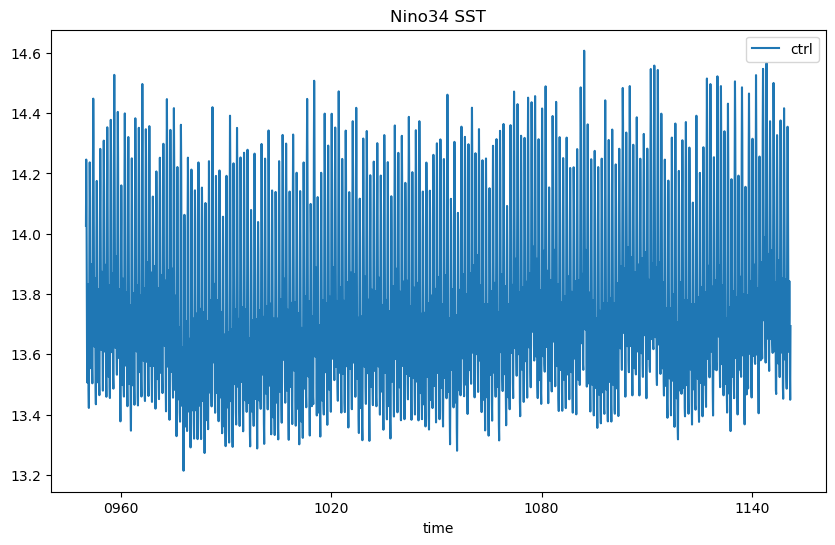

In [26]:
plt.figure(figsize = (10,6))
#NINO34_sst(VC).plot(label = "no_bias")
ctrl.mean(['latitude', 'longitude']).plot(label = "ctrl")#.sel(time = slice('0951-01-01','0966-12-31' )).plot(label = "ctrl")
#NINO34_sst(HA_r).sel(time = slice('0951-01-01','0966-12-31' )).plot(label = "restor_vals")
plt.legend()
plt.title("Nino34 SST")

Text(0.5, 1.0, 'Nino34 SST')

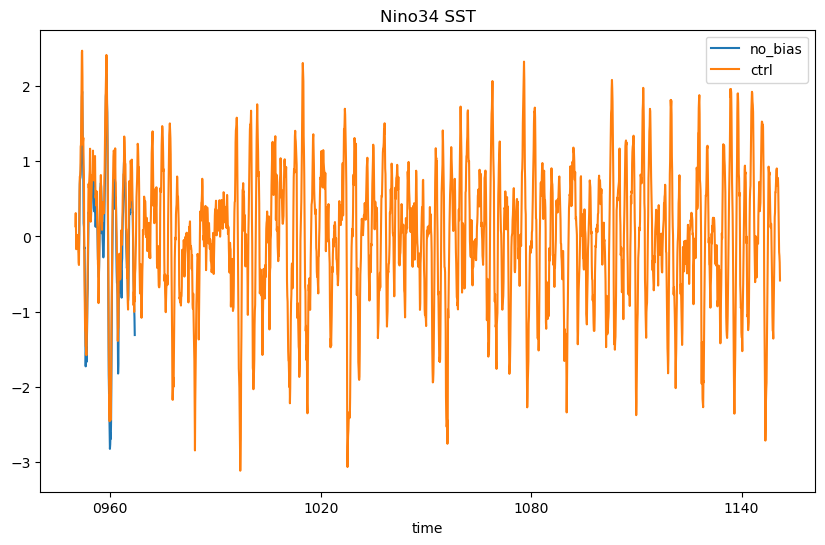

In [24]:
plt.figure(figsize = (10,6))
NINO34(VC).plot(label = "no_bias")
NINO34(ctrl).plot(label = "ctrl")#.sel(time = slice('0951-01-01','0966-12-31' )).plot(label = "ctrl")
#NINO34_sst(HA_r).sel(time = slice('0951-01-01','0966-12-31' )).plot(label = "restor_vals")
plt.legend()
plt.title("Nino34 SST")

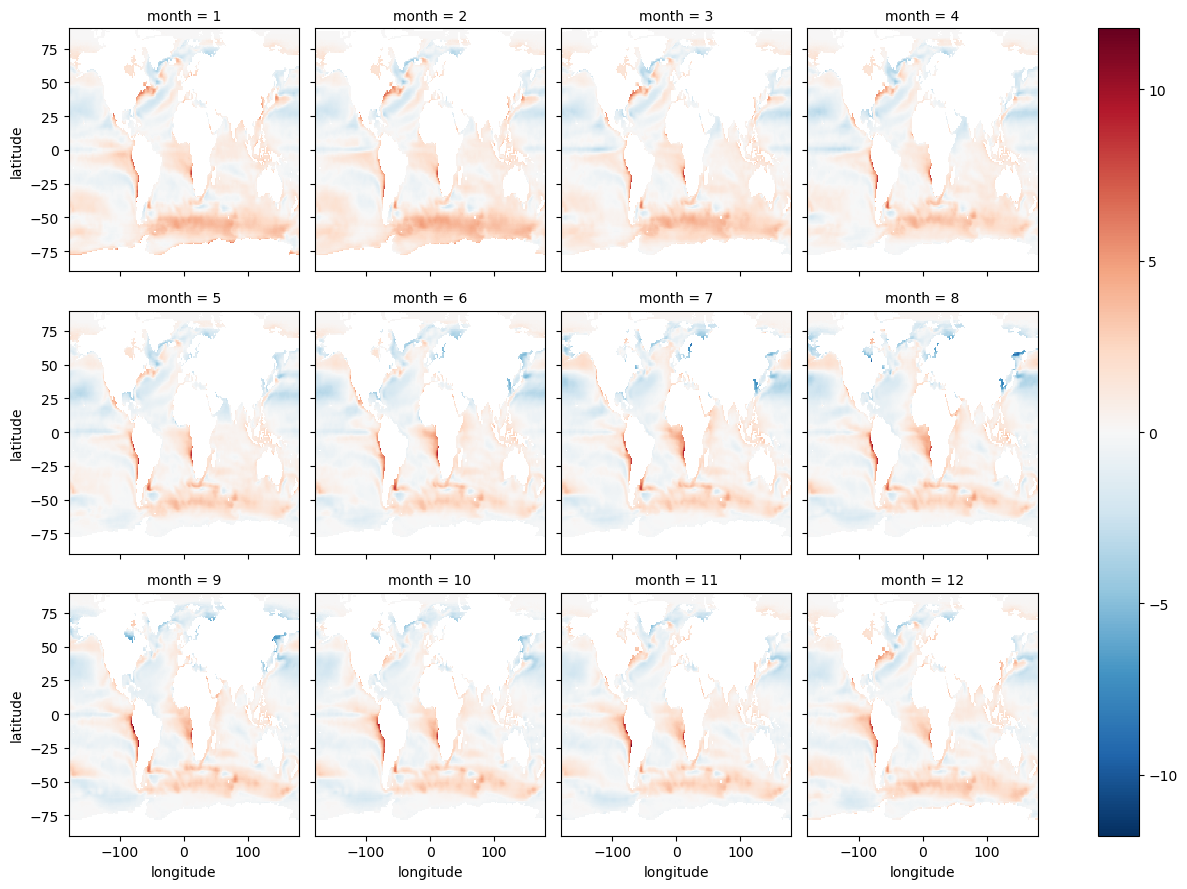

In [29]:
((ctrl).groupby('time.month').mean('time') - (HA_r).groupby('time.month').mean('time')).plot(col = 'month', col_wrap = 4)
#(HA_r).groupby('time.month').mean('time').plot()

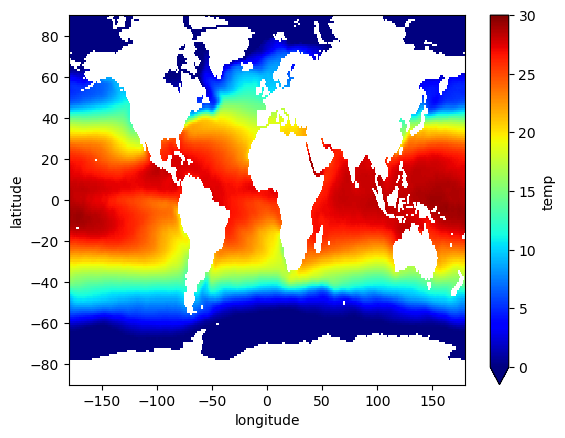

In [33]:
(HA_r).mean('time').plot(vmin = 0, vmax = 30, cmap = 'jet')

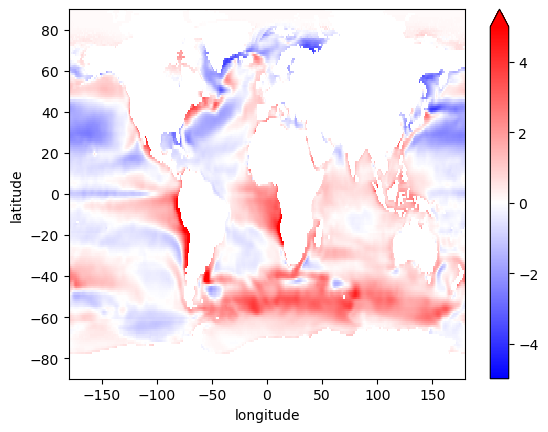

In [36]:
((ctrl).mean('time') - (HA_r).mean('time')).plot(vmin = -5, vmax = 5, cmap = 'bwr')


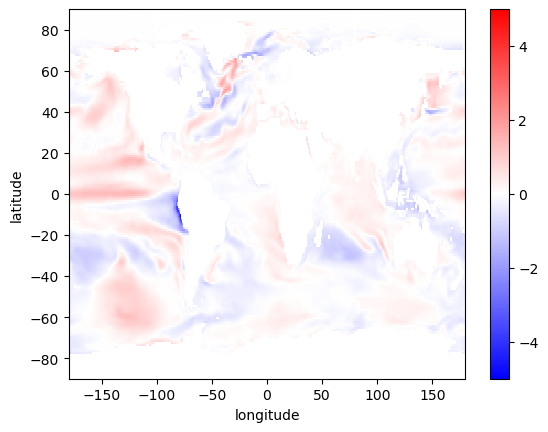

In [35]:
((VC).mean('time') - (ctrl).mean('time')).plot(vmin = -5, vmax = 5, cmap = 'bwr')


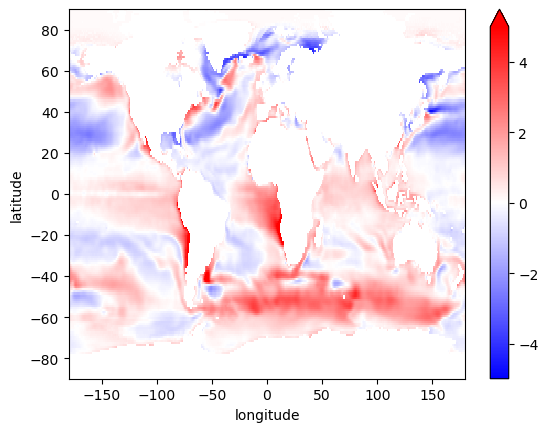

In [34]:
((VC).mean('time') - (HA_r).mean('time')).plot(vmin = -5, vmax = 5, cmap = 'bwr')


In [69]:
N34 = NINO34(VC)
N34_c = NINO34(ctrl)

In [57]:
year1_t = VC.sel(time = slice('0951-01-01','0951-12-31' )).time.rename({"time":"TIME"})
year2_t = VC.sel(time = slice('0952-01-01','0952-12-31' )).time.rename({"time":"TIME"})

In [82]:
for i in range(951, 1151, 1):
    F_SST = xr.open_dataset(f"/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_{i:04d}.nc", decode_times=False)
    F_SST = F_SST.temp.drop("DEPTH1_1")[0]
    year_t = ctrl.sel(time = slice(f'{i:04d}-01-01',f'{i:04d}-12-31' )).time.rename({"time":"TIME"})
    F_SST = F_SST.assign_coords({"TIME": year_t}).rename({"TIME":"time"})
    if i == 951:
        HAD_ANOM = F_SST
    else:
        HAD_ANOM = xr.concat([HAD_ANOM, F_SST], dim = 'time')

In [86]:
HAD_ANOM.to_netcdf("/g/data/e14/sm2435/PO_model_clim/HAD_anoms_full.nc")

In [81]:
year_t

<xarray.DataArray 'time' (TIME: 12)>
array([cftime.DatetimeGregorian(951, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 2, 15, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 4, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 5, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 6, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 7, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 8, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 9, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(951, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * TIME     (TIME) object 0951-01-16 12:00:00 ... 0951-12-16 12:00:00

In [62]:
#load in SST data used to force the experiement
F_SST1 = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0951.nc", decode_times=False)
F_SST2 = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HAD_anom/HadISST_ctrl_anom_0952.nc", decode_times=False)

In [63]:
F_SST1 = F_SST1.temp.drop("DEPTH1_1")[0]
F_SST2 = F_SST2.temp.drop("DEPTH1_1")[0]
F_SST1 = F_SST1.assign_coords({"TIME": year1_t}).rename({"TIME":"time", "GRID_Y_T": "latitude", "GRID_X_T":"longitude"})
F_SST2 = F_SST2.assign_coords({"TIME": year2_t}).rename({"TIME":"time", "GRID_Y_T": "latitude", "GRID_X_T":"longitude"})
HAD_anom = xr.concat([F_SST1, F_SST2], dim = 'time')

In [73]:
HAD_anom

<xarray.DataArray 'temp' (time: 24, latitude: 300, longitude: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) object 0951-01-16 12:00:00 ... 0952-12-16 12:00:00
  * latitude   (latitude) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * longitude  (longitude) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
Attributes:
    long_name:    Climatology SST restoring
    units:        degrees K
    valid_range:  [-10. 500.]

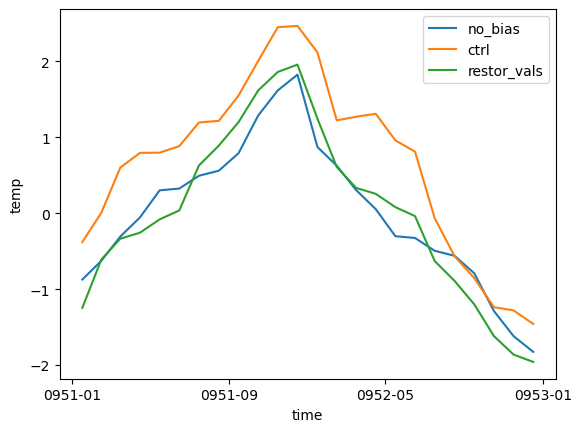

In [70]:
N34.plot(label = "no_bias")
N34_c.sel(time = slice('0951-01-01','0952-12-31' )).plot(label = "ctrl")
NINO34(HAD_anom).plot(label = "restor_vals")
plt.legend()

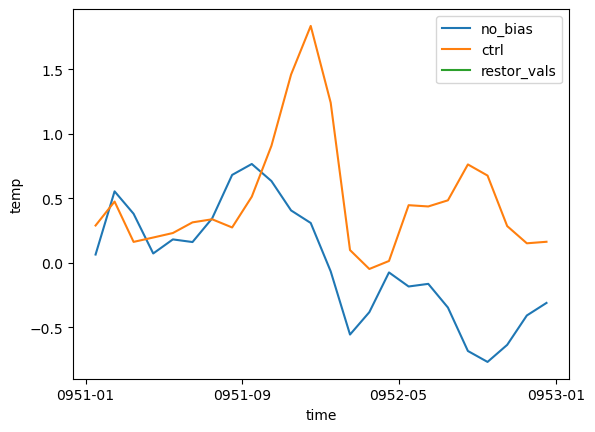

In [72]:
dmi(VC).plot(label = "no_bias")
dmi(ctrl).sel(time = slice('0951-01-01','0952-12-31' )).plot(label = "ctrl")
dmi(HAD_anom).plot(label = "restor_vals")
plt.legend()

In [32]:
ds = xr.open_mfdataset("/scratch/e14/sm2435/archive/cy286/history/atm/cy286a.pm09*.nc").fld_s05i216

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

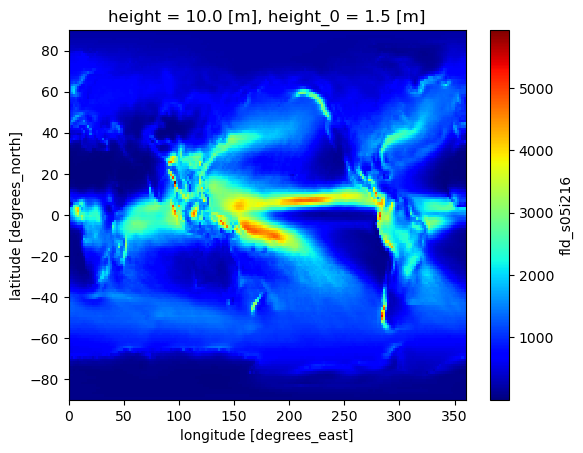

In [41]:
(ds*2.6e6).groupby("time.month").mean("time").sum('month').plot(cmap = "jet")

SyntaxError: invalid syntax (3943774606.py, line 1)